# <center> Практика

К нам пришёл заказчик, которому необходимо проанализировать клиентов торгового центра и выделить разные группы покупателей, чтобы понять, как дальше развивать услуги торгового центра, магазины каких сегментов открывать.

В файле содержится основная информация о покупателе: идентификатор, возраст, пол, доход, индекс расходов. Индекс расходов считается на основе таких параметров, как поведение клиента и данные о покупках, и принимает значение от 1 до 100.

Также в файле содержится информация об истинных метках кластеров для клиентов (они нам пригодятся позже).

In [153]:
#Импорты
import pandas as pd
import numpy as np #для матричных вычислений
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import completeness_score

#визуализация
import plotly.express as px
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

In [154]:
#Загрузка данных

df = pd.read_csv('data/segmented_customers.csv')
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              205 non-null    int64  
 1   Gender                  205 non-null    object 
 2   Age                     203 non-null    float64
 3   Annual Income (k$)      203 non-null    float64
 4   Spending Score (1-100)  204 non-null    float64
 5   cluster                 201 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.7+ KB


None

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [155]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [156]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

df.head()

,customer_id,gender,age,annual_income,spending_score,cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [157]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


In [158]:

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

In [159]:

def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig


X = df[['age', 'annual_income', 'spending_score']]

In [160]:
dbscan_cluster = DBSCAN().fit(X)

get_3d_visualization(df, dbscan_cluster.labels_)

In [161]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=12, min_samples=5)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

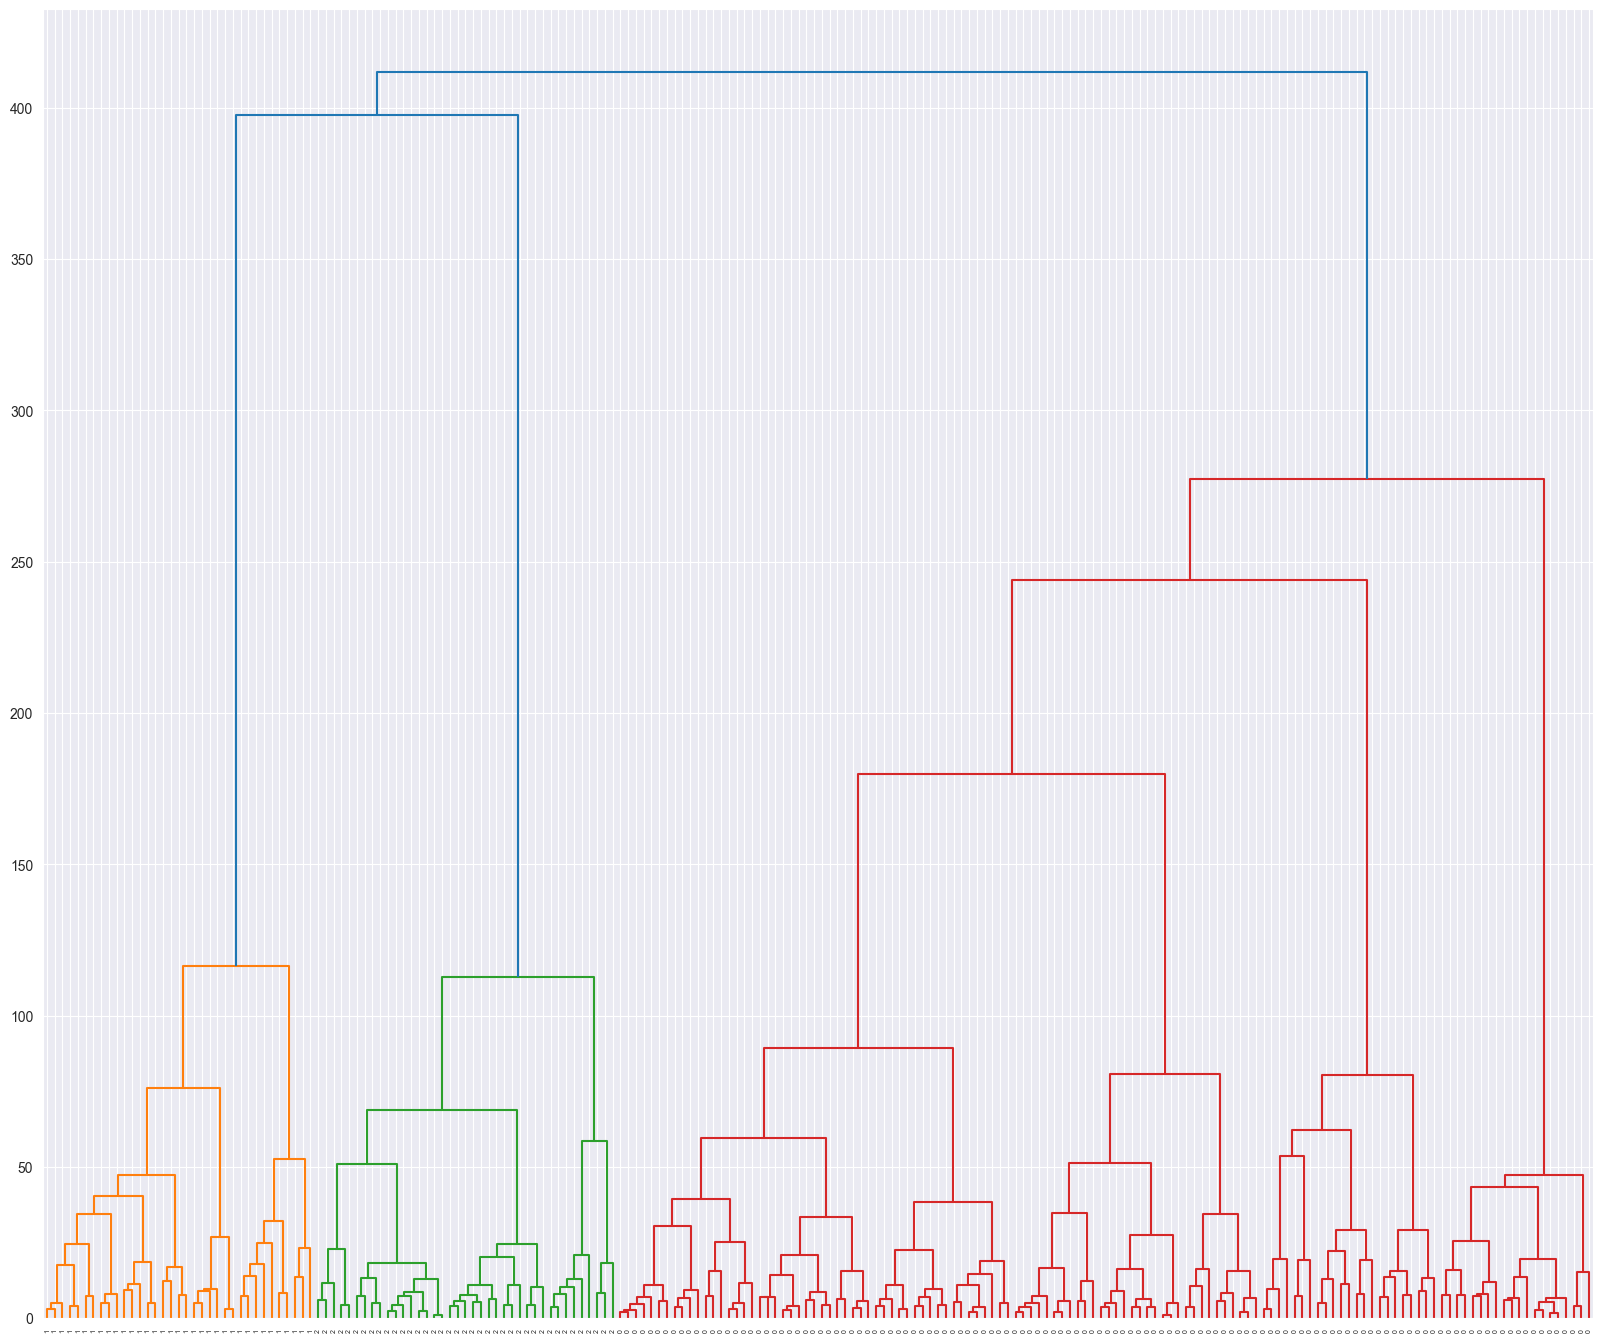

In [162]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

df['aggl_res_3'] = get_aggl_clustering(X, 3)

linked = linkage(X, 'ward')

plt.figure(figsize=(20,17))

dendrogram(Z=linked,
           orientation='top',
           labels=get_aggl_clustering(X, 3),
           distance_sort='descending',
           show_leaf_counts=True)

plt.show()

In [163]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

<Axes: xlabel='cluster', ylabel='silhouette'>

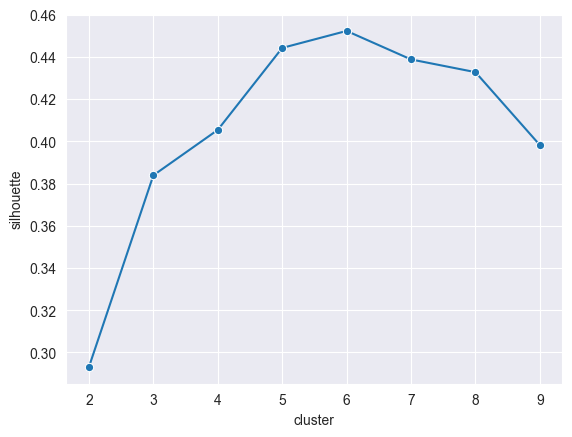

In [164]:
# напишем функцию, как и при подсчете метода локтя
# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    # проведём агломеративную кластеризацию с заданным количеством кластеров
    res = get_aggl_clustering(X, cluster_num)
    # рассчитаем коэффициент силуэта
    silhouette = silhouette_score(X, res)
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)
# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [165]:
#Оцениваем качество кластеризации
print(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))

0.9012847747610448
